__File:__ Risk Project 2031611.ipynb <br>
<h1> <center> Risk Analytics - Term Project </center> </h1>
<center> Lecturer: Dr Colin Rowat </center> 
<center> Student ID: 2031611 </center> 

## Problems

The aim was to use Python to build a trading system that maximises relative wealth against the MSCI ACWI benchmark during its deployment period, subject to the constraint that its expected shortfall (ES) in the 1% tail is less than 1% of its value [5]. The portfolio contains 5 stocks from the Oil, Gas & Consumable Fuels (GICS code: 101020) industry.

$$\max\limits_{w} ~~~ (w^TS_{stocks} - S_{benchmark})$$   

$$ s.~t. ~~~~~~~ ES_{0.01} < 0.01*V_{0} $$  

$$w^{T}S_{stocks} \leqslant V_{0}$$

$$\Sigma_{i=1}^{5} w_i = 1$$
$$ where ~~~ V_{0} = \$ 1~mil $$ 

## Algorithm Overview

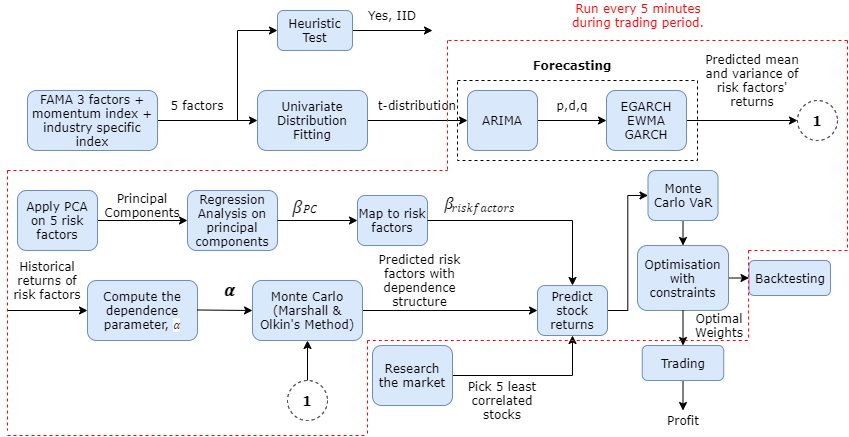

## Document Structure

1. Import Time Series <br>
2. Research the Market <br>
2. Risk Factors Model<br>
3. Heuristic Test <br>
4. Fit Univariate Distribution <br>
5. Forecasting <br>
6. Copula <br>
7. Optimisation <br>
8. Backtesting <br>
9. Trading <br>

## 0.0 Install the python packages 

In [1]:
######################
# Installing Packages
######################
!pip install alpha_vantage
!pip install numpy
!pip install pandas
!pip install arch
!pip install copulae
!pip install matplotlib
!pip install itertools
!pip install seaborn
!pip install scipy
!pip install statsmodels
!pip install sklearn
!pip install warnings
!pip install time
!pip install datetime

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


## 0.1 Import the python libraries

In [2]:
#########################
# Importing packages
#########################

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from arch import arch_model
import seaborn as sns
from itertools import chain
import scipy.stats as st
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import uniform
from scipy.interpolate import interp1d
from scipy.stats import t
from copulae import ClaytonCopula, GumbelCopula, FrankCopula
import warnings
warnings.filterwarnings('ignore')
from numpy.linalg import inv
import time

## 1. Import Time Series Data

In [3]:
###################
# Global Variables
###################

# Total stocks needed for the portfolio
PORTFOLIO_SIZE = 5

# List of major stocks in the Oil, Gas & Consumable Fuels (GICS code: 101020) industry
tot_tickers = ['TOT','XOM','APA','MRO','CVX','MMP','RDS-A','NAT','CPG','PBR',
                'CSL','HFC','VLO','EC','PSX','CVI','COG','BP','COP','OXY']

# List all the risk factors for the Fama-French Factor Model
value_factors = ['SPYV', 'SPYG'] 
size_factors = ['IWM', 'DJI']  
momentum_factors = ['MTUM'] 
market_factors = ['SPY']
sector_index = ['^SP400-101020'] # S&P 400 Oil, Gas & Consumable Fuels (Industry) Index
tot_risk_factors = market_factors + value_factors + size_factors + momentum_factors + sector_index
# Benchmark
benchmark = ['ACWI']

In [4]:
#################################################
# Functions for Getting data from Alpha-Vantage
#################################################

def get_ticker(ticker, key='E9FYA5V9FWQ677IZ', interval='1min'):
    # Choose your output format, or default to JSON (python dict)
    ts = TimeSeries(key, output_format='pandas')
    ti = TechIndicators(key)
    # Get ticker close time series
    tick_data = ts.get_intraday(symbol=ticker, interval=interval, outputsize='full')[0]['4. close']
    return tick_data.iloc[::-1]


def get_all_tickers(all_tickers, key='E9FYA5V9FWQ677IZ', interval='1min'): ############## CALL THIS FUNCTION
    all_price_data = pd.concat([get_ticker(tic, key, interval)
                                for tic in all_tickers], axis=1,
                               keys=all_tickers).fillna(method='ffill', axis=0).dropna(axis=0)
    return all_price_data

stock_price_data = get_all_tickers(tot_tickers)
stock_price_data

,TOT,XOM,APA,MRO,CVX,MMP,RDS-A,NAT,CPG,PBR,CSL,HFC,VLO,EC,PSX,CVI,COG,BP,COP,OXY
date,,,,,,,,,,,,,,,,,,,,
2020-02-13 09:31:00,49.0700,61.0100,28.2300,11.1300,111.5142,59.4550,51.1700,3.5701,3.1900,14.8700,161.610,44.4332,84.6982,19.8450,90.8700,34.4300,14.9000,36.1100,58.8972,42.0000
2020-02-13 09:32:00,49.0968,61.0022,28.0910,10.9304,111.5900,59.2700,51.1645,3.5101,3.1801,14.9005,161.610,44.4300,84.4900,19.8107,90.8100,34.4712,14.9255,36.1113,58.8521,42.0215
2020-02-13 09:33:00,49.0600,61.0010,28.1055,10.8452,111.7418,59.3400,51.1000,3.5000,3.1901,14.8900,161.610,44.4650,84.3200,19.8503,90.9150,34.3800,14.9500,36.1096,58.9000,42.0407
2020-02-13 09:34:00,49.0500,61.0272,28.1409,10.9666,111.7436,59.3525,51.0900,3.4951,3.1900,14.8805,161.610,44.4925,84.1800,19.9000,90.7340,34.4900,14.9955,36.0700,58.9519,42.1500
2020-02-13 09:35:00,49.1200,61.1250,28.1512,10.9405,111.8115,59.3402,51.0600,3.4900,3.1900,14.8948,161.610,44.5100,84.2885,19.8808,90.8400,34.4300,14.9956,36.0400,59.0100,42.1618
2020-02-13 09:36:00,49.1700,61.0900,28.1511,10.9754,111.7700,59.7900,51.1300,3.5000,3.2000,14.9050,162.250,44.4700,84.4300,19.8808,90.7640,34.4300,14.9906,36.0830,58.9524,42.2717
2020-02-13 09:37:00,49.2300,61.0800,28.2300,10.9200,111.8000,59.7900,51.1600,3.5000,3.2000,14.8700,162.250,44.4900,84.5000,19.9000,90.8738,34.5600,15.0600,36.1000,58.9500,42.2595
2020-02-13 09:38:00,49.2700,61.0200,28.3000,10.9700,111.8400,59.6100,51.1900,3.4800,3.2000,14.8700,162.250,44.5500,84.4400,19.9000,90.9000,34.5600,15.1000,36.1200,59.0000,42.2300
2020-02-13 09:39:00,49.3700,61.1400,28.3900,11.0350,111.9500,59.6900,51.2650,3.4900,3.2200,14.8600,161.950,44.7212,84.3322,19.9200,90.9400,34.7100,15.1500,36.1619,59.2000,42.3500


## 2. Research the Market

Out of the 20 top performing stocks, 5 least correlated stocks were selected because it would give the greatest diversification effect.

In [5]:
#####################################################
# Functions to calculate Covariance and Correlation
#####################################################

def get_price_cov_stocks(stock_price_data):
    return stock_price_data.cov()

def get_price_corr_stocks(stock_price_data):
    return stock_price_data.corr()

In [6]:
#########################################################
# Functions to find the least and most volatile stocks
#########################################################

def get_least_risky_stocks(stock_price_data, count=PORTFOLIO_SIZE):
    # Find the covariance matrix of the data
    cov_matrix = get_price_cov_stocks(stock_price_data)
    # List of top 5 least volatile stocks
    lvol_ticks = [cov_matrix.index[i] for v, i in
                  sorted((v, i) for i, v in enumerate([cov_matrix.iloc[i, i] for i in range(len(cov_matrix))]))[
                  0:count]]
    return lvol_ticks

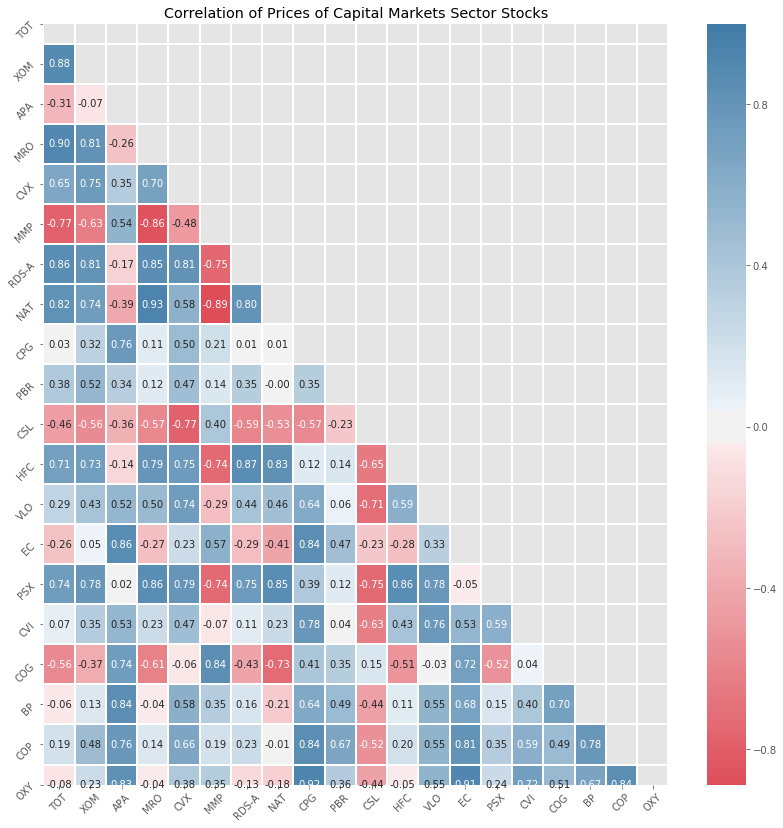

In [7]:
###########################################################################
# Function to plot the Heatmap of correlation for the stocks in the sector
###########################################################################

def plot_corr_all_stocks(stock_price_data): ############## CALL THIS FUNCTION
    # Get the correlation matrix of the stocks
    corr_matrix = get_price_corr_stocks(stock_price_data)
        # Visualizing correlation matrix
    cmap = sns.diverging_palette(h_neg=10,
                                 h_pos=240,
                                 as_cmap=True)

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    plt.figure(figsize=(14, 14))
    plot = sns.heatmap(corr_matrix, center=0,
                mask=mask, cmap=cmap, linewidths=1,
                annot=True, fmt=".2f")
    plt.title("Correlation of Prices of Capital Markets Sector Stocks")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    return plot

plot_corr_all_stocks(stock_price_data)

In [8]:
###########################################################################################
# Function to get the least correlated stocks from the sector and add it to the portfolio
###########################################################################################

def find_least_corr_stocks(stock_price_data, count = PORTFOLIO_SIZE): ############## CALL THIS FUNCTION
    # Get the correlation matrix of the stocks
    corr_matrix = get_price_corr_stocks(stock_price_data)

    # The greatest number of least volatile stocks to be selected
    count_for_corr = int(corr_matrix.shape[0]/2 if 10 < corr_matrix.shape[0] < 30 else 5)

    # Removing highly correlated features
    # Create positive correlation matrix
    corr_df = corr_matrix.abs()

    # Find the stocks with the least volatility
    lvol_ticks = get_least_risky_stocks(stock_price_data, count_for_corr)
    corr_list = sorted(list(chain.from_iterable(sorted((val, tic, corr_tic)
                    for val, corr_tic in
                    sorted((val, corr_df.index[ind]) for ind, val in enumerate(corr_df.loc[str(tic), :]))
                    if tic != corr_tic) for tic in lvol_ticks)), key=lambda x: x[0])

    # Provides the final set of 5 tickers with least correlation among them
    portfolio_stocks = set()
    for val, tic, corr_tic in corr_list:
        portfolio_stocks.add(tic)
        if len(portfolio_stocks) == count: break

    return list(portfolio_stocks)

portfolio_stocks = find_least_corr_stocks(stock_price_data)
portfolio_stocks

['RDS-A', 'COP', 'CPG', 'NAT', 'PBR']

Then, calculate the compound returns of the stocks and risk factors. The formula is give by,

**$$Compound~Return = \ln\frac{P_t}{P_{t-1}}$$**

## 3. Risk Factors Model

The FAMA-French Three Factors Model was chosen to predict stock returns. It has three factors: size of firms, book-to-market values, and excess return on the market. In other words, the three factors used are SMB (small minus big), HML (high minus low) and the market risk [5]. Two addtional factors - momentum and sector specific indices were also included to improve risk evaluation.

$$ r = R_f + \beta(R_m - R_f) + b_sSML +b_vHML + mMTM + sSCT+\alpha $$

Where $ r $ = rate of return, $ R_f  $ = Risk free return rate, $ R_m$ = Return of the market portfolio, $SMB$ = Small Minus Big, $HML$ = High Minus Low i.e. book to market values, $MTM$ = Momentum Index, $SCT$ = Sector Specific Index and $\alpha, \beta$ = regression parameters. Here the risk free rate is *negligible* and will not be considered in the model. <br>
- $SMB$ refers to the differential returns of small stocks minus big stocks, where small and big refer simply to the market capitalisation of the stocks. <br>
- $HML$ stands for the returns of a portfolio of high book-to-market stocks minus a portfolio of low book to market stocks. <br>
- $MTM$ used in this model is the *MTUM* factor index. It is to track the performance of an index that measures the performance of U.S. large- and mid-capitalization stocks exhibiting relatively higher momentum characteristics, before fees and expenses.<br>
- $SCT$ used in this model is the *S&P 400 Oil, Gas & Cnsmble Fuel(Ind)* index. It is a stock market index from S&P Dow Jones Indices. The index serves as a barometer for the U.S. mid-cap Oil, Gas & Cnsmble Fuel sector equities and is the most widely followed mid-cap index.

In [9]:
##############################################################
# Function to get the returns of the stocks and risk factors
##############################################################

def find_returns(stock_price_data):
    return np.log(stock_price_data).diff().fillna(method='ffill', axis=0).dropna(axis=0)


def get_returns(tickers):
    if isinstance(tickers, str):
        price_data = get_ticker(tickers)
    else:
        price_data = get_all_tickers(tickers)
    return find_returns(price_data)

In [10]:
#########################################################################################################
# Function to get the returns of the Fama French risk factors and create risk-factor returns dataframe
#########################################################################################################

def get_ff_risk_factors(market_factors=['SPY'],          
                        value_factors=['SPYV', 'SPYG'],
                        size_factors=['IWM', 'DJI'],
                        momentum_factors=['MTUM'],
                        sector_index=['^SP400-101020']):
    # Market factor
    market_factor_returns = get_returns(market_factors)

    # Value factors (HML)
    value_returns = get_returns(value_factors)
    value_factor_returns = value_returns[value_factors[0]] - value_returns[value_factors[1]]

    # Size factors (SML)
    size_returns = get_returns(size_factors)
    size_factor_returns = size_returns[size_factors[0]] - size_returns[size_factors[1]]

    # Momentum factor
    momentum_factor_returns = get_returns(momentum_factors)

    # Sector Index factor
    sector_factor_returns = get_returns(sector_index)

    factor_returns = pd.concat([market_factor_returns,
                                size_factor_returns,
                                value_factor_returns,
                                momentum_factor_returns,
                                sector_factor_returns], axis=1,
                                ignore_index=True).fillna(method='ffill', axis=0).dropna(axis=0)

    factor_returns.columns = ['Market', 'SMB', 'HML', 'Momentum', 'Sector']

    # Remove Outliers
    factor_returns = factor_returns[(np.abs(st.zscore(factor_returns)) < 4).all(axis=1)]

    return factor_returns

risk_factor_returns = get_ff_risk_factors()

## 4. Heuristic Test

The first test is to split the compound returns time series into two halves. Then compare the respective histograms. If the compound returns are time-invariant, the two histograms should look very similar to each other [3].

The second test consists of plotting the time series against its lagged values on a scatter plot. If the compound returns are independently identically distributed, the scatter plot must be symmetrical with respect to the reference axes and resemble a circular cloud [3].

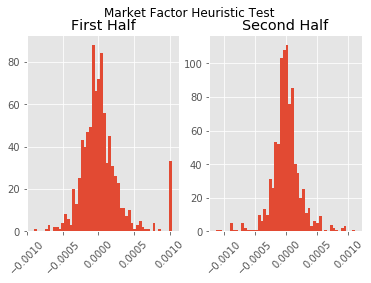

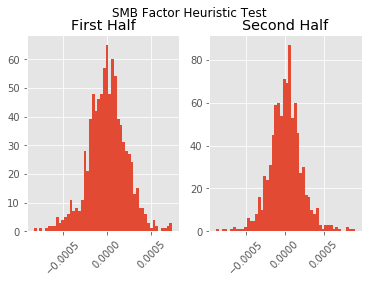

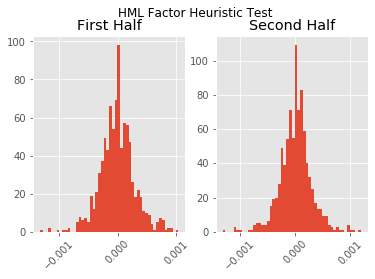

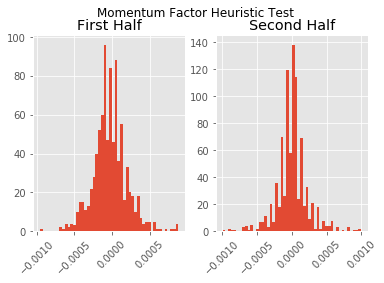

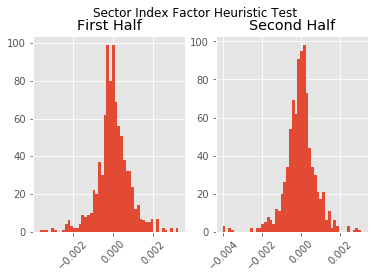

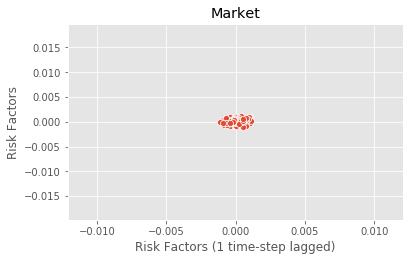

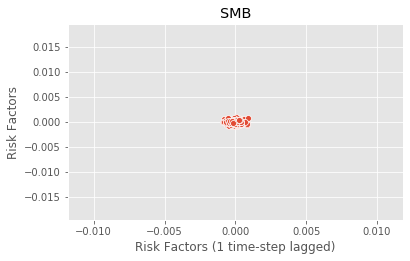

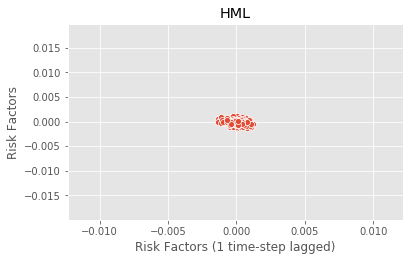

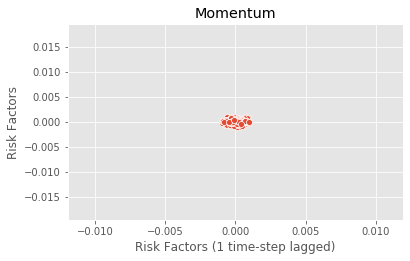

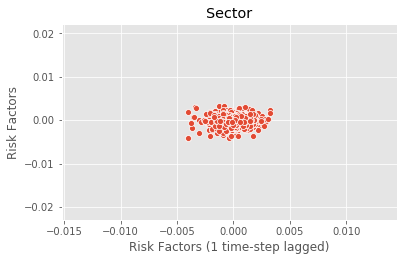

In [11]:
##########################################################################################
# Function to run the heuristics test on the risk factor returns to see if they are IID
##########################################################################################

def heuristic_test_plots(risk_factor_returns): 
    '''
    Performs two Heuristic tests for the risk factor returns to check if they are IID:
        1) Split the series in two halves and plot the histogram of each half. Both the histograms
           must resemble each other.
        2) Scatter-plot the time series of the total returns against the same time series lagged by
           one estimation interval. The scatter-plot must resemble a circular cloud.
    :param risk_factor_returns: Returns of all risk factors
    :return: Plot of histogram and scatter plot for each risk factor
    '''
    # risk_factors = risk_factor_returns.columns
    # number_of_factors = risk_factor_returns.shape[1]
    number_of_datapoints = risk_factor_returns.shape[0]
    first_half_df = risk_factor_returns.iloc[:int(number_of_datapoints/2), :]
    second_half_df = risk_factor_returns.iloc[int(number_of_datapoints/2):, :]
    number_of_bins = int(np.sqrt(number_of_datapoints / 0.7))

    # Market Factor Histogram Heuristic Test
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Market Factor Heuristic Test")
    fig.subplots_adjust(bottom=0.2)
    _ = first_half_df['Market'].hist(bins=number_of_bins, ax=axes[0])
    _ = axes[0].set_title("First Half")
    _ = plt.setp(axes[0].get_xticklabels(), rotation=45)
    _ = second_half_df['Market'].hist(bins=number_of_bins, ax=axes[1])
    _ = axes[1].set_title("Second Half")
    _ = plt.setp(axes[1].get_xticklabels(), rotation=45)

    # SMB Factor Histogram Heuristic Test
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("SMB Factor Heuristic Test")
    fig.subplots_adjust(bottom=0.2)
    _ = first_half_df['SMB'].hist(bins=number_of_bins, ax=axes[0])
    _ = axes[0].set_title("First Half")
    _ = plt.setp(axes[0].get_xticklabels(), rotation=45)
    _ = second_half_df['SMB'].hist(bins=number_of_bins, ax=axes[1])
    _ = axes[1].set_title("Second Half")
    _ = plt.setp(axes[1].get_xticklabels(), rotation=45)

    # HML Factor Histogram Heuristic Test
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("HML Factor Heuristic Test")
    fig.subplots_adjust(bottom=0.2)
    _ = first_half_df['HML'].hist(bins=number_of_bins, ax=axes[0])
    _ = axes[0].set_title("First Half")
    _ = plt.setp(axes[0].get_xticklabels(), rotation=45)
    _ = second_half_df['HML'].hist(bins=number_of_bins, ax=axes[1])
    _ = axes[1].set_title("Second Half")
    _ = plt.setp(axes[1].get_xticklabels(), rotation=45)

    # Momentum Factor Histogram Heuristic Test
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Momentum Factor Heuristic Test")
    fig.subplots_adjust(bottom=0.2)
    _ = first_half_df['Momentum'].hist(bins=number_of_bins, ax=axes[0])
    _ = axes[0].set_title("First Half")
    _ = plt.setp(axes[0].get_xticklabels(), rotation=45)
    _ = second_half_df['Momentum'].hist(bins=number_of_bins, ax=axes[1])
    _ = axes[1].set_title("Second Half")
    _ = plt.setp(axes[1].get_xticklabels(), rotation=45)

    # Sector Index Factor Histogram Heuristic Test
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Sector Index Factor Heuristic Test")
    fig.subplots_adjust(bottom=0.2)
    _ = first_half_df['Sector'].hist(bins=number_of_bins, ax=axes[0])
    _ = axes[0].set_title("First Half")
    _ = plt.setp(axes[0].get_xticklabels(), rotation=45)
    _ = second_half_df['Sector'].hist(bins=number_of_bins, ax=axes[1])
    _ = axes[1].set_title("Second Half")
    _ = plt.setp(axes[1].get_xticklabels(), rotation=45)
    
    # Scatter Plot 
    factors = ['Market','SMB','HML','Momentum','Sector']
    titles = ['Market Scatter Plot','SMB Scatter Plot','HML Scatter Plot','Momentum Scatter Plot','Sector Scatter Plot']
    for i in range(len(factors)):
        fig, axes = plt.subplots(1)
        fig.subplots_adjust(bottom=0.2)
        sns.scatterplot(risk_factor_returns[factors[i]][:-1],
                    risk_factor_returns[factors[i]].shift(1).dropna(axis=0))
        plt.title(factors[i])
        plt.xlabel('Risk Factors (1 time-step lagged)')
        plt.ylabel('Risk Factors')
        plt.show()
    
heuristic_test_plots(risk_factor_returns)

In [12]:
############################################################################################
# Functions to create a risk factor and stock return matrix for each stock in the portfolio
############################################################################################

def join_stock_risk_factors(stock_returns, risk_factor_returns, stock):
    stock_factor_data = pd.concat([stock_returns[stock], risk_factor_returns], axis=1,
                                  ignore_index=True).fillna(method='ffill', axis=0).dropna(axis=0)
    stock_factor_data.columns = [stock, 'Market', 'SMB', 'HML', 'Momentum', 'Sector']
    return stock_factor_data


def get_stock_factor_df(portfolio_stocks, benchmark=['ACWI']): ############## CALL THIS FUNCTION
    total_tickers = portfolio_stocks + benchmark
    risk_factor_returns = get_ff_risk_factors()
    stock_returns = get_returns(total_tickers)
    stock_factor_dict = {}
    for stock in total_tickers:
        stock_factor_dict[stock] = join_stock_risk_factors(stock_returns, risk_factor_returns, stock)
    return stock_factor_dict

stock_factor_dict = get_stock_factor_df(portfolio_stocks)
stock_factor_dict

{'RDS-A':                         RDS-A    Market       SMB       HML      Momentum  \
 date                                                                        
 2020-02-13 09:33:00 -0.001066  0.000103  0.000459 -0.000579 -4.443786e-04   
 2020-02-13 09:34:00 -0.000587  0.000103  0.000459 -0.000579 -4.443786e-04   
 2020-02-13 09:35:00 -0.000392 -0.000713 -0.000444  0.000469 -6.665926e-04   
 2020-02-13 09:36:00  0.001370 -0.000713 -0.000444  0.000469 -6.665926e-04   
 2020-02-13 09:37:00  0.000587 -0.000059  0.000613  0.000789  2.220495e-04   
 2020-02-13 09:38:00  0.000586 -0.000059  0.000613  0.000789  2.220495e-04   
 2020-02-13 09:39:00  0.001464  0.000535  0.000239  0.000168  7.116307e-04   
 2020-02-13 09:40:00 -0.000683 -0.000178 -0.000401  0.000151 -3.414386e-04   
 2020-02-13 09:41:00  0.000029  0.000149 -0.000167 -0.000222 -2.961647e-04   
 2020-02-13 09:42:00 -0.000420 -0.000119  0.000119 -0.000678 -1.746960e-04   
 2020-02-13 09:43:00  0.000976  0.000030  0.000104 -0.0

The test results suggest it is safe to assume that the compound returns are time-invariant i.i.d series.

## 5. Fit the Univariate Distribution 

In [13]:
########################################################################################
# Functions to fit the univariate risk-factor distributions and plot the distributions
########################################################################################

def plot_risk_factor_distribution(risk_factor_return, figsize=(10, 8), style='bmh'): ############## CALL THIS FUNCTION
    # Get the distribution and parameters
    distribution, param = best_fit_distribution(risk_factor_return)
    if not isinstance(risk_factor_return, pd.Series):
        risk_factor_return = pd.Series(risk_factor_return)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        dist_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        #qq_ax = plt.subplot2grid(layout, (1, 0))
        #pp_ax = plt.subplot2grid(layout, (1, 1))

        sns.distplot(risk_factor_return, ax=dist_ax)
        dist_ax.set_title('Distribution Plots')
        #sm.qqplot(risk_factor_return, line='s', ax=qq_ax)
        #qq_ax.set_title('QQ Plot')
        #st.probplot(risk_factor_return, sparams=param[1:], plot=pp_ax)#, dist=eval("st."+distribution))
        plt.tight_layout()
    return


def best_fit_distribution(risk_factor_return, bins=200): ############## CALL THIS FUNCTION
    """Model data by finding best fit distribution to data"""
    if not isinstance(risk_factor_return, pd.Series):
        risk_factor_return = pd.Series(risk_factor_return)
    # Get histogram of original data
    y, x = np.histogram(risk_factor_return, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [st.cauchy, st.expon, st.lognorm, st.norm, st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(risk_factor_return) # Shape, location, scale

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

factors = ['Market','SMB','HML','Momentum','Sector']
print('                                             Degree of Freedom       Mean              Variance')
for i in factors:
    dist = best_fit_distribution(risk_factor_returns[i])
    print('The Best Fit Distribution of ',  i,'is', dist) 

                                             Degree of Freedom       Mean              Variance
The Best Fit Distribution of  Market is ('t', (1.9905042886699487, -5.2746810254168975e-06, 0.00013788659048168085))
The Best Fit Distribution of  SMB is ('t', (1.9860085434166561, 7.425572890088161e-06, 0.00014165390511116326))
The Best Fit Distribution of  HML is ('t', (1.9893879793502542, -1.5937563418083632e-06, 0.0001812776547055899))
The Best Fit Distribution of  Momentum is ('t', (1.9921391855053192, -1.0347773427677559e-05, 0.00013575507859944937))
The Best Fit Distribution of  Sector is ('t', (1.9931106307985593, -1.2056232694134941e-05, 0.00046463474497948306))


The above results shows that t-distribution is the most appropriate fit to all 5 of the compound returns.

## 6. Forecasting

While returns themselves may show little or no autocorrelation. There is a strong positive autocorrelation in squared returns. This feature is regarded as GARCH, because conditional volatility varies over time. One of the most important features of high frequency returns on equity is that volatility tends to cluster [8].

### ARIMA Model

Applying the Box-Jenskins method to the ARIMA model to find the best parameters p,d and q. These parameters are then used for the forecasting models later.

$$ y_{t} = \mu + \phi_{1}y_{t-1}+ ... + \phi_{p}y_{t-p} - \theta_{1}\epsilon_{t-1}...-\theta_{q}\epsilon_{t-q}$$ 
<centre> where $y$ = returns time series, $\epsilon$ = lagged residuals </centre>

In [14]:
#############################################################################
# Find the parameters of the risk factors returns using the ARIMA model
#############################################################################

def box_jenkins_ARIMA_params(risk_factor_return):
    # The Augmented Dicky-Fuller test:
    # - Tests only for trend non-stationarity
    # - Null hypothesis is time series is non-stationary
    if not isinstance(risk_factor_return, pd.Series):
        risk_factor_return = pd.Series(risk_factor_return)
    adf = adfuller(risk_factor_return)
    # print('ADF statistic: ', adf[0])
    # print('p-value: ', adf[1])
    if adf[1] < 0.05:
        # print("The Series is Stationary")
        # When certain orders don't work and provide value errors while fitting
        # Loop over AR order
        order_aic_bic = []
        for p in range(3):
            # Loop over MA order
            for q in range(3):
                try:
                    # Fit Model
                    model = SARIMAX(risk_factor_return, order=(p, 0, q))
                    results = model.fit(disp=False)
                    # Add order and scores to list
                    # print(p, q, results.aic, results.bic)
                    order_aic_bic.append((p, q, results.aic, results.bic))
                except:
                    pass

        order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])
        order_df.sort_values('aic', inplace=True)
        if order_df.empty:
            return (1, 0, 1)
        else:
            return (order_df.iloc[0, 0], 0,  order_df.iloc[0, 1])


### Forecasting Model

Three forecasting methods are used to compare the estimation performance.

#### GARCH

$$\sigma_{t}^2 = \omega + \alpha y_{t-q}^2 + \beta\sigma_{t-p}^2$$
where $\sigma$ = volatility of returns,$y$ = returns times series, $p$ and $q$ are the lags for them respectively.

#### EGARCH

$$\ln(\sigma_{t}) = \omega + \Sigma_{i=1}^q \alpha_{i}g(z_{t-i}) + \Sigma_{j=1}^p\gamma_{j}\ln(\sigma_{t-j})$$
where
$$ g(z_{t}) = \theta z_{t} + \gamma(|z_{t}|-\mathbb{E}|z_{t}|)$$
$$ z_{t} = \epsilon_{t}/\sqrt(\sigma_{t})$$
$$ z_{t} \sim t(\upsilon,0,1)$$

#### EWMA

$$ EWMA(x_{t-1},...,x_{1})|\lambda) = \frac{x_{t-1}+\lambda x_{t-2}+\lambda^2x_{t-3}+...+\lambda^{t-2}x_1}{1+\lambda+\lambda^2+...+\lambda^{t-2}}$$
where
$$\lambda = smoothing ~const, 0 < \lambda < 1$$

In [15]:
#######################################################################################
# Functions to run the GARCH and EWMA model using the parameters from the ARIMA model
#######################################################################################
def garch_fit(risk_factor_return, garch_type='EGARCH', first_obs=None, last_obs=None):
    '''
    Garch model is being calculated in 10000 * percentage rather than returns as the larger
    magnitude helps it to converge, hence it is multiplied by 10000.
    :param risk_factor_return:
    :return:
    '''
    distribution, param = best_fit_distribution(risk_factor_return)
    p, d, q = box_jenkins_ARIMA_params(risk_factor_return)
    if distribution == 't':
        garch_model = arch_model(risk_factor_return * 10000, vol=garch_type, p=int(p), o=1, q=int(q), dist='skewt')
    else:
        garch_model = arch_model(risk_factor_return * 10000, vol=garch_type, p=int(p), o=1, q=int(q), dist='normal')
    res = garch_model.fit(update_freq=5, disp='off', first_obs=first_obs, last_obs=last_obs)
    return res, garch_model

def garch_forecast(risk_factor_return, garch_type='EGARCH', horizon=5, method='simulation'):
    res, garch_model = garch_fit(risk_factor_return, garch_type=garch_type)
    forecasts = res.forecast(horizon=horizon, method=method)
    horizon_index = 'h.' + str(horizon)
    forecast_mean = forecasts.mean.iloc[-1][horizon_index]
    forecast_variance = forecasts.variance.iloc[-1][horizon_index]
    return (forecast_mean, forecast_variance)

def ewma_estimation(risk_factor_return, decay_param=0.9, min_periods=100):
    mu_ema = risk_factor_return.ewm(decay_param, min_periods=min_periods).mean()[-1]
    sigma_ema = risk_factor_return.ewm(decay_param, min_periods=min_periods).std()[-1]
    return mu_ema, sigma_ema

### Principal Component Analysis

Principal component analysis is based on the spectral decomposition of a correlation matrix. It is the simplest of many orthogonalisation  techniques that transform a set of correlated variables into a set of uncorrelated variables [7].

The risk factor returns covariance matrix is given by $ V = T^{-1}X'X $, where the columns of $X$ are denoted $x_{1},x_{2},...,x_{5}$ (individual risk factor returns) and $T$ is the number of observations on each return.  <br>

Then, a diagonal matrix (denoted by $\Lambda$) of eigenvalues of $V$ and the orthogonal matrix (denoted by $W$) of eigenvectors of $V$. In $\Lambda$, order the eigenvalues (and their corresponding eigenvectors in $W$) from largest to smallest. <br>

The matrix of principal components of $V$ is a $T \times 5$ matrix $P$ defined as $P = XW$. Each principal component is the linear combination of the columns of $X$, where the weights are chosen in such a way that the first principal component explains the most variation and the second component explains the greatest amount of remaining variation, etc. <br>

The total variations in $X$ is the sum of the eigenvalues of $V$, i.e. $\lambda_{1} +\lambda_{2}+...+\lambda_{5}$. Hence, the proportion of this total variation that is explained by the mth principal component is
$$\frac{\lambda_{m}}{\lambda_{1} +\lambda_{2}+...+\lambda_{5}}$$

In [16]:
#######################################################################################################################
# Functions to run the Linear Regression on the PCA components of the risk factors to the factor betas for each stock
#######################################################################################################################

def find_all_stock_benchmark_betas(stock_factor_dict, portfolio_stocks, benchmark=['ACWI']):
    all_betas_dict = {}
    stock_benchmark_list = portfolio_stocks + benchmark
    for stock in stock_benchmark_list:
        factors = list(stock_factor_dict[stock].columns[1:])
        factor_data = stock_factor_dict[stock][factors]
        stock_data = stock_factor_dict[stock][stock]
        all_betas_dict[stock] = find_factor_betas(factor_data, stock_data)
    return all_betas_dict


def pca(factor_data, variance_ratio=0.85):
    pipe = Pipeline([ ('scaler', StandardScaler()),
                      ('reducer', PCA())])
    principal_components = pipe.fit_transform(factor_data)
    variance_ratio_explained = pipe.steps[1][1].explained_variance_ratio_
    factor_variance_df = pd.DataFrame(zip(factor_data.columns, variance_ratio_explained),
                                      columns=['Factors', 'Explained Variance'])
    factor_variance_df.set_index(keys='Factors', inplace=True)
    # Select relevant principal components
    number_of_components = sum(variance_ratio_explained.cumsum() < variance_ratio)
    principal_components_df = pd.DataFrame(principal_components,
                                           columns=['PC0', 'PC1', 'PC2', 'PC3', 'PC4'],
                                           index=factor_data.index)
    return principal_components_df.iloc[:, :number_of_components], pipe.steps[1][1].components_, factor_variance_df


def find_factor_betas(factor_data, stock_data):
    # Get PCA components
    pc, eigen_vectors, eigen_values_df = pca(factor_data)

    # OLS Regression
    # Fit data and find betas using OLS regression
    reg_all = LinearRegression()
    lr_model = reg_all.fit(pc, stock_data)

    # From Principal Components betas find the Factor Betas
    pc_betas = lr_model.coef_
    factor_betas = np.dot(eigen_vectors[:, :pc.shape[1]], pc_betas)
    factor_betas_df = pd.DataFrame(zip(factor_data.columns, factor_betas),
                                      columns=['Factors', 'betas'])
    factor_betas_df.set_index(keys='Factors', inplace=True)
    return factor_betas_df

## 7. Copula 

After getting the marginal univariate distributions of the 5 stocks and the predicted returns at the investment horizon. Copula was used to obtain the joint density function by taking their dependence structure into account. The Clayton copula from the Archimedeans family was selected to model the compound returns as it has negative tail dependence and stock returns' negative tail dependence tends to be greater during stresful periods.

A simulation algorithm proposed by Marshall and Olkin (1988) for the compound construction of copulas was used (see pg. 189 in [6]). <br>
*Clayton Case* <br>
 * Generate a random variate $\gamma$ Gamma(1,1/$\alpha$) (hence $\gamma$ has Laplace transform $\tau(s) = (1+s)^{-1/\alpha}$
 * Independently of the previous step, generate $U_1$,$U_2$,...,$U_n$ independent Uniform(0,1) random variables
 * For $k = 1, 2,...,n$ calculate $X_k = F^{-1}_k(U^{*}_k)$ where
 $$ U^{*}_k = \tau(-\frac{1}{\gamma}lnU_k)$$
 

In [17]:
############################################################################################################################
# Functions to find the copula and generate multivariate simulations from the selected copula for Monte Carlo calculations
############################################################################################################################

def get_copula_theta(risk_factor_returns, dim = PORTFOLIO_SIZE): 
    theta = []
    log_lik = []

    # Clayton Copula
    clay_cop = ClaytonCopula(dim=dim)
    _ = clay_cop.fit(risk_factor_returns)
    theta.append(clay_cop.params)
    log_lik.append(-clay_cop.log_lik(risk_factor_returns))

    # Gumbel Copula
    gum_cop = GumbelCopula(dim=dim)
    _ = gum_cop.fit(risk_factor_returns)
    theta.append(gum_cop.params)
    log_lik.append(-gum_cop.log_lik(risk_factor_returns))

    # Frank Copula
    frank_cop = FrankCopula(dim=dim)
    _ = frank_cop.fit(risk_factor_returns)
    theta.append(frank_cop.params)
    log_lik.append(-frank_cop.log_lik(risk_factor_returns))

    copula_df = pd.DataFrame(zip(theta, log_lik),
                             columns=['theta', 'log likelihood'],
                             index=['Clayton', 'Gumbel', 'Frank'])
    copula_df.sort_values('log likelihood', inplace=True)
    return copula_df


def copula_returns(number_simulations, theta, number_factors=5):
    copula_sims_list = []
    unif_rv_df = uniform.rvs(size=number_simulations * number_factors).reshape(number_simulations, number_factors)
    for i in range(number_simulations):
        gamma_rv = np.random.gamma(shape=1, scale=1. / theta)
        copula_sims_list.append([((1. + (-np.log(u) / gamma_rv)) ** (-1. / theta)) for u in unif_rv_df[i, :]])
    return copula_sims_list


def generate_garch_sim_copula(risk_factor_return, garch_type='EGARCH', horizon=5, size=1000):
    dist, param = best_fit_distribution(risk_factor_return)
    if garch_type == 'EWMA':
        mean, variance = ewma_estimation(risk_factor_return)
        return t.rvs(df=param[0],
                     size=size,
                     loc=mean,
                     scale=np.sqrt(variance))
    else:
        mean, variance = garch_forecast(risk_factor_return, garch_type=garch_type, horizon=horizon)
        return t.rvs(df=param[0],
                     size=size,
                     loc=mean/10000,
                     scale=np.sqrt(variance)/10000)


def copula_factor_sims(risk_factor_returns, garch_type='EGARCH', number_simulations=1000):
    number_simulations = number_simulations if number_simulations < risk_factor_returns.shape[0] else risk_factor_returns.shape[0]
    copula_df = get_copula_theta(risk_factor_returns)
    theta = copula_df.iloc[0, 0]
    copula_unif_rv = pd.DataFrame(copula_returns(number_simulations, theta))
    ppf = pd.DataFrame()
    for i in range(5):
        # Get fore-casted simulations
        risk_factor_simulations = generate_garch_sim_copula(risk_factor_returns.iloc[:, i],
                                                            garch_type=garch_type,
                                                            size=number_simulations)
        ppf[i] = inverted(risk_factor_simulations)(copula_unif_rv[i])
        if any(np.isinf(ppf.iloc[:, i])) or any(np.isnan(ppf.iloc[:, i])):
            ppf[i] = np.array(risk_factor_returns.iloc[:number_simulations, i])
    ppf.columns = ['Market', 'SMB', 'HML', 'Momentum', 'Sector']
    return ppf


def inverted(data):
    sample = data
    sample_edf = ECDF(sample)
    slope_changes = sorted(set(sample))
    sample_edf_values_at_slope_changes = [sample_edf(item) for item in slope_changes]
    inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes, fill_value="extrapolate")
    return inverted_edf

In [18]:
#############################################################################
# Function to get the stock returns from the factor returns
#############################################################################

def get_stock_from_factor_returns(stock_factor_dict, garch_type='EGARCH', number_stocks=PORTFOLIO_SIZE, number_simulations=1000):
    risk_factor_returns = list(stock_factor_dict.values())[0].iloc[:, 1:]
    number_simulations = number_simulations if number_simulations < risk_factor_returns.shape[0] else risk_factor_returns.shape[0]
    try:
        ppf = copula_factor_sims(risk_factor_returns, garch_type=garch_type, number_simulations=number_simulations)
    except:
        # print("************* AN EXCEPTION OCCURRED *****************")
        # print(ValueError)
        ppf = risk_factor_returns.iloc[:number_simulations, :]
    betas_dict = find_all_stock_benchmark_betas(stock_factor_dict, list(stock_factor_dict.keys())[:number_stocks])
    stock_returns_dict = {}
    for stock, betas in betas_dict.items():
        stock_returns_dict[stock] = np.dot(ppf, betas).flatten()
        stock_returns_dict[stock] = np.dot(ppf, betas).flatten()
    stock_returns_df = pd.DataFrame(stock_returns_dict)
    return stock_returns_df

## 8.Optimisation

### Optimisation Algorithm
- Generate some random weights, they can be negative to represent short selling.
- Using Monte Carlo, simulate the risk factor returns from the Copula Multivariate distribution and generate the corresponding stock returns. 
- Multiply the weights with the generated stock returns to generate the portfolio returns and get the portfolio returns distribution.
- Subtract the simulated forecasted benchmark returns from the generated portfolio returns to obtain active returns distribution.
- From the active returns distribution, get the negative 1% tail and find its mean to get the Expected shortfall.
- Repeat this procedure for each set of weights and select the weight which provides the maximum expected active return over the benchmark for which the expected shortfall falls below the 1% portfolio cutoff.

In [19]:
#################################################################################################################
# Function to optimize over the weights to maximum active returns over the benchmark for 1% Expected shortfall 
#################################################################################################################

def optimize(stock_factor_dict, garch_type='EGARCH', number_simulations=1000): 
    # generate a sets of weight
    random_weight_df = pd.DataFrame(np.random.uniform(0, 2, 5 * number_simulations).reshape(number_simulations, 5))
    final_random_weight_df = random_weight_df.divide(np.array(random_weight_df.sum(axis=1)).reshape(-1, 1), axis=1)

    for row_index in range(np.random.randint(final_random_weight_df.shape[0])):
        indx = list(np.random.choice([0, 1, 2, 3, 4], size=4, replace=False))
        final_random_weight_df.iloc[row_index, indx[0]] = final_random_weight_df.iloc[row_index, indx[0]] + 0.2
        final_random_weight_df.iloc[row_index, indx[1]] = final_random_weight_df.iloc[row_index, indx[1]] - 0.2
        final_random_weight_df.iloc[row_index, indx[2]] = final_random_weight_df.iloc[row_index, indx[2]] + 0.2
        final_random_weight_df.iloc[row_index, indx[3]] = final_random_weight_df.iloc[row_index, indx[3]] - 0.2

    tail_loss_limit = -(1 + 0.01) ** (1 / 420) - 1  # 1% ES annualized to be converted to minutely
    max_return = 0
    record = 0

    # calculate porfolio's expected return of porfolio under different weight
    stock_benchmark_return = get_stock_from_factor_returns(stock_factor_dict, garch_type=garch_type, number_simulations=1000)
    if garch_type == 'EWMA':
        stock_return = stock_benchmark_return.iloc[:, :-1]
        benchmark_return = stock_benchmark_return.iloc[:, -1]
    else:
        stock_return = stock_benchmark_return.iloc[:, :-1] * 10000
        benchmark_return = stock_benchmark_return.iloc[:, -1] * 10000
    portfolio_return = np.dot(final_random_weight_df, stock_return.T)
    active_return = np.array([portfolio_return[i, :]-np.array(benchmark_return) for i in range(len(benchmark_return))])
    mean_return = active_return.mean(axis=1)

    # calculate cvar
    active_return.sort(axis=1)
    one_percent_index = int(active_return.shape[1]/100)
    value_tail = active_return[:, :one_percent_index]
    expected_shortfall = np.mean(value_tail, axis=1)

    # find out the maximum return rate portfolio under constraint
    for i in range(len(expected_shortfall)):
        if expected_shortfall[i] < tail_loss_limit:
            continue
        else:
            if mean_return[i] < max_return:
                continue
            else:
                max_return = mean_return[i]
                record = i

    # print(max_return)
    weight_df = pd.DataFrame(zip(list(stock_return.columns), final_random_weight_df.iloc[record, :]),
                             columns=['stocks', 'weights'])
    weight_df.set_index(keys='stocks', inplace=True)
    return weight_df.T, expected_shortfall[record]

## 9. Backtesting

In [20]:
######################################################################################
# Function for Backtesting the E-GARCH, GARCH and EWMA
######################################################################################
def backtesting():
    # Get the stock prices
    all_stock_price = get_all_tickers(tot_tickers)
    portfolio_stocks = find_least_corr_stocks(all_stock_price)
    portfolio_stock_price = all_stock_price[portfolio_stocks]
    stock_factor_dict = get_stock_factor_df(portfolio_stocks)

    # General variables for bl
    initial_fund = 1000000  # Initial investment, 1million dollars
    trading_interval = 1  # in minute

    # Starter variables for EGARCH
    num_shares_egarch = dict((stock, []) for stock in portfolio_stocks)
    remaining_fund_egarch = []
    port_valuelist_egarch = []
    tot_assets_egarch = []
    expected_shortfall_egarch = []
    profit_per_trade_egarch = []

    # Starter variables for GARCH
    num_shares_garch = dict((stock, []) for stock in portfolio_stocks)
    remaining_fund_garch = []
    port_valuelist_garch = []
    tot_assets_garch = []
    expected_shortfall_garch = []
    profit_per_trade_garch = []

    # Starter variables for EWMA
    num_shares_ewma = dict((stock, []) for stock in portfolio_stocks)
    remaining_fund_ewma = []
    port_valuelist_ewma = []
    tot_assets_ewma = []
    expected_shortfall_ewma = []
    profit_per_trade_ewma = []

    # Trading Algorithm
    k = 1
    while k <= 13:
        start = time.time()

        # Trading ended
        if k == 13:
            print('#####################---Trading Terminated---#####################')
            # EGARCH
            print('----EGARCH Estimation Gives----')
            print('The Final Asset Value is ' + str(np.round(port_valuelist_egarch[-1] + remaining_fund_egarch[-1],2)) + ' USD')
            print('Profit/Loss = ' + str(port_valuelist_egarch[-1] + remaining_fund_egarch[-1] - initial_fund) + ' USD')
            # GARCH
            print('----GARCH Estimation Gives----')
            print('The Final Asset Value is ' + str(np.round(port_valuelist_garch[-1] + remaining_fund_garch[-1],2)) + ' USD')
            print('Profit/Loss = ' + str(port_valuelist_garch[-1] + remaining_fund_garch[-1] - initial_fund) + ' USD')
            # EWMA
            print('----EWMA Estimation Gives----')
            print('The Final Asset Value is ' + str(np.round(port_valuelist_ewma[-1] + remaining_fund_ewma[-1],2)) + ' USD')
            print('Profit/Loss = ' + str(port_valuelist_ewma[-1] + remaining_fund_ewma[-1] - initial_fund) + ' USD')
            break
        print('#####################Trade', k, 'starts#####################')


        ######BACKTESTING USE THIS##########
        # Get the minutely price data (start)--------------------------------------------------------------------
        price_df = portfolio_stock_price.iloc[100 * (k - 1):100 * k, :]  # rolling to simulate live data
        # Get the minutely price data (end)----------------------------------------------------------------------------
        ######BACKTESTING USE THIS##########

        # Compute the log returns (start)----------------------------------------------------------------------------
        # compound_returns = (1 + find_returns(price_df)).cumprod()
        # Compute the log returns (end)----------------------------------------------------------------------------

        # The weights supposed to be generated by optimisation function, but I use random weights here.
        weights_egarch, es_egarch = optimize(stock_factor_dict)
        weights_garch, es_garch = optimize(stock_factor_dict, garch_type='GARCH')
        weights_ewma, es_ewma = optimize(stock_factor_dict, garch_type='EWMA')

        # Expected Shortfalls
        expected_shortfall_egarch.append(es_egarch)
        expected_shortfall_garch.append(es_garch)
        expected_shortfall_ewma.append(es_ewma)


        # Calculate the current portfolio value(start)-----------------------------------------------------------
        if k == 1:
            # EGARCH
            remaining_fund_egarch.append(0)
            tot_assets_egarch.append(initial_fund + remaining_fund_egarch[-1])
            # GARCH
            remaining_fund_garch.append(0)
            tot_assets_garch.append(initial_fund + remaining_fund_garch[-1])
            # EWMA
            remaining_fund_ewma.append(0)
            tot_assets_ewma.append(initial_fund + remaining_fund_ewma[-1])
            print('The initial investment amount is: ' + str(np.round(initial_fund,2)) + ' USD')
        else:
            # EGARCH
            port_value_egarch = 0  # reset the portfolio value to zero
            for stock in portfolio_stocks:
                # Re-evaluate portfolio value after receiving new price
                port_value_egarch += num_shares_egarch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]  # multiply previous stocks holding by new price
            # Re-evalute total assets (previous remaining fund + updated portfolio value)
            tot_assets_egarch.append(remaining_fund_egarch[-1] + port_value_egarch)
            profit_per_trade_egarch.append(tot_assets_egarch[-1] - tot_assets_egarch[-2])

            # GARCH
            port_value_garch = 0  # reset the portfolio value to zero
            for stock in portfolio_stocks:
                # Re-evaluate portfolio value after receiving new price
                port_value_garch += num_shares_garch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]  # multiply previous stocks holding by new price
            # Re-evalute total assets (previous remaining fund + updated portfolio value)
            tot_assets_garch.append(remaining_fund_garch[-1] + port_value_garch)
            profit_per_trade_garch.append(tot_assets_garch[-1] - tot_assets_garch[-2])

            # EWMA
            port_value_ewma = 0  # reset the portfolio value to zero
            for stock in portfolio_stocks:
                # Re-evaluate portfolio value after receiving new price
                port_value_ewma += num_shares_ewma[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]  # multiply previous stocks holding by new price
            # Re-evalute total assets (previous remaining fund + updated portfolio value)
            tot_assets_ewma.append(remaining_fund_ewma[-1] + port_value_ewma)
            profit_per_trade_ewma.append(tot_assets_ewma[-1] - tot_assets_ewma[-2])



        # Calculate the current portfolio value(end)---------------------------------
        # Reset portfolio value before trading.
        # EGARCH
        port_value_egarch = 0
        for stock in portfolio_stocks:
            num_shares_egarch[stock].append(int(float(weights_egarch[stock]) * tot_assets_egarch[-1] / stock_price_data.iloc[-1, portfolio_stocks.index(stock)]))
            port_value_egarch += num_shares_egarch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]
        port_valuelist_egarch.append(port_value_egarch)
        remaining_fund_egarch.append(tot_assets_egarch[-1] - port_valuelist_egarch[-1])
        print('----EGARCH Estimation Gives----')
        print('The Current Asset Value is ' + str(np.round(port_valuelist_egarch[-1], 2)) + ' USD')    
        for stock in portfolio_stocks:
            print('The portfolio currently holds ' + str(np.round(num_shares_egarch[stock][-1], 2)) + ' shares of ' + stock)

        # GARCH
        port_value_garch = 0
        for stock in portfolio_stocks:
            num_shares_garch[stock].append(int(float(weights_garch[stock]) * tot_assets_garch[-1] /stock_price_data.iloc[-1, portfolio_stocks.index(stock)]))
            port_value_garch += num_shares_garch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]
        port_valuelist_garch.append(port_value_garch)
        remaining_fund_garch.append(tot_assets_garch[-1] - port_valuelist_garch[-1])
        print('----GARCH Estimation Gives----')
        print('The Current Asset Value is ' + str(np.round(port_valuelist_garch[-1], 2)) + ' USD')    
        for stock in portfolio_stocks:
            print('The portfolio currently holds ' + str(np.round(num_shares_garch[stock][-1], 2)) + ' shares of ' + stock)

        # EWMA
        port_value_ewma = 0
        for stock in portfolio_stocks:
            num_shares_ewma[stock].append(int(float(weights_ewma[stock]) * tot_assets_ewma[-1] / stock_price_data.iloc[-1, portfolio_stocks.index(stock)]))
            port_value_ewma += num_shares_ewma[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]
        port_valuelist_ewma.append(port_value_ewma)
        remaining_fund_ewma.append(tot_assets_ewma[-1] - port_valuelist_ewma[-1])
        print('----EWMA Estimation Gives----')
        print('The Current Asset Value is ' + str(np.round(port_valuelist_ewma[-1], 2)) + ' USD')    
        for stock in portfolio_stocks:
            print('The portfolio currently holds ' + str(np.round(num_shares_ewma[stock][-1], 2)) + ' shares of ' + stock)


        k += 1

        # Pause after each trade to gather data
        end = time.time()
        print('Analysis runtime: '  + str(np.round((end - start),2)) + ' s')
        time.sleep(trading_interval*60- (end - start))

## 10. Trading

In [21]:
######################################################################################
# Function for Trading the E-GARCH, GARCH and EWMA
######################################################################################

# Get the stock prices
all_stock_price = get_all_tickers(tot_tickers)
portfolio_stocks = find_least_corr_stocks(all_stock_price)
portfolio_stock_price = all_stock_price[portfolio_stocks]

# General variables for bl
initial_fund = 1000000  # Initial investment, 1million dollars
trading_interval = 5  # in minute

# Starter variables for EGARCH
num_shares_egarch = dict((stock, []) for stock in portfolio_stocks)
remaining_fund_egarch = []
port_valuelist_egarch = []
tot_assets_egarch = []
expected_shortfall_egarch = []
profit_per_trade_egarch = []

# Starter variables for GARCH
num_shares_garch = dict((stock, []) for stock in portfolio_stocks)
remaining_fund_garch = []
port_valuelist_garch = []
tot_assets_garch = []
expected_shortfall_garch = []
profit_per_trade_garch = []

# Starter variables for EWMA
num_shares_ewma = dict((stock, []) for stock in portfolio_stocks)
remaining_fund_ewma = []
port_valuelist_ewma = []
tot_assets_ewma = []
expected_shortfall_ewma = []
profit_per_trade_ewma = []

# Trading Algorithm
k = 1
while k <= 13:
    start = time.time()

    # Trading ended
    if k == 13:
        print('#####################---Trading Terminated---#####################')
        # EGARCH
        print('----EGARCH Estimation Gives----')
        print('The Final Asset Value is ' + str(np.round(port_valuelist_egarch[-1] + remaining_fund_egarch[-1],2)) + ' USD')
        print('Profit/Loss = ' + str(port_valuelist_egarch[-1] + remaining_fund_egarch[-1] - initial_fund) + ' USD')
        # GARCH
        print('----GARCH Estimation Gives----')
        print('The Final Asset Value is ' + str(np.round(port_valuelist_garch[-1] + remaining_fund_garch[-1],2)) + ' USD')
        print('Profit/Loss = ' + str(port_valuelist_garch[-1] + remaining_fund_garch[-1] - initial_fund) + ' USD')
        # EWMA
        print('----EWMA Estimation Gives----')
        print('The Final Asset Value is ' + str(np.round(port_valuelist_ewma[-1] + remaining_fund_ewma[-1],2)) + ' USD')
        print('Profit/Loss = ' + str(port_valuelist_ewma[-1] + remaining_fund_ewma[-1] - initial_fund) + ' USD')
        break
    print('#####################Trade', k, 'starts#####################')

   
    ######BACKTESTING USE THIS##########
    # Get the minutely price data (start)--------------------------------------------------------------------
    # price_df = portfolio_stock_price.iloc[100 * (k - 1):100 * k, :]  # rolling to simulate live data
    stock_price_data = get_all_tickers(portfolio_stocks)
    stock_factor_dict = get_stock_factor_df(portfolio_stocks)
    # Get the minutely price data (end)----------------------------------------------------------------------------


    # The weights supposed to be generated by optimisation function, but I use random weights here.
    weights_egarch, es_egarch = optimize(stock_factor_dict)
    weights_garch, es_garch = optimize(stock_factor_dict, garch_type='GARCH')
    weights_ewma, es_ewma = optimize(stock_factor_dict, garch_type='EWMA')

    # Expected Shortfalls
    expected_shortfall_egarch.append(es_egarch)
    expected_shortfall_garch.append(es_garch)
    expected_shortfall_ewma.append(es_ewma)


    # Calculate the current portfolio value(start)-----------------------------------------------------------
    if k == 1:
        # EGARCH
        remaining_fund_egarch.append(0)
        tot_assets_egarch.append(initial_fund + remaining_fund_egarch[-1])
        # GARCH
        remaining_fund_garch.append(0)
        tot_assets_garch.append(initial_fund + remaining_fund_garch[-1])
        # EWMA
        remaining_fund_ewma.append(0)
        tot_assets_ewma.append(initial_fund + remaining_fund_ewma[-1])
        print('The initial investment amount is: ' + str(np.round(initial_fund,2)) + ' USD')
    else:
        # EGARCH
        port_value_egarch = 0  # reset the portfolio value to zero
        for stock in portfolio_stocks:
            # Re-evaluate portfolio value after receiving new price
            port_value_egarch += num_shares_egarch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]  # multiply previous stocks holding by new price
        # Re-evalute total assets (previous remaining fund + updated portfolio value)
        tot_assets_egarch.append(remaining_fund_egarch[-1] + port_value_egarch)
        profit_per_trade_egarch.append(tot_assets_egarch[-1] - tot_assets_egarch[-2])

        # GARCH
        port_value_garch = 0  # reset the portfolio value to zero
        for stock in portfolio_stocks:
            # Re-evaluate portfolio value after receiving new price
            port_value_garch += num_shares_garch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]  # multiply previous stocks holding by new price
        # Re-evalute total assets (previous remaining fund + updated portfolio value)
        tot_assets_garch.append(remaining_fund_garch[-1] + port_value_garch)
        profit_per_trade_garch.append(tot_assets_garch[-1] - tot_assets_garch[-2])

        # EWMA
        port_value_ewma = 0  # reset the portfolio value to zero
        for stock in portfolio_stocks:
            # Re-evaluate portfolio value after receiving new price
            port_value_ewma += num_shares_ewma[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]  # multiply previous stocks holding by new price
        # Re-evalute total assets (previous remaining fund + updated portfolio value)
        tot_assets_ewma.append(remaining_fund_ewma[-1] + port_value_ewma)
        profit_per_trade_ewma.append(tot_assets_ewma[-1] - tot_assets_ewma[-2])



    # Calculate the current portfolio value(end)---------------------------------
    # Reset portfolio value before trading.
    # EGARCH
    port_value_egarch = 0
    for stock in portfolio_stocks:
        num_shares_egarch[stock].append(int(float(weights_egarch[stock]) * tot_assets_egarch[-1] / stock_price_data.iloc[-1, portfolio_stocks.index(stock)]))
        port_value_egarch += num_shares_egarch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]
    port_valuelist_egarch.append(port_value_egarch)
    remaining_fund_egarch.append(tot_assets_egarch[-1] - port_valuelist_egarch[-1])
    print('----EGARCH Estimation Gives----')
    print('The Current Asset Value is ' + str(np.round(port_valuelist_egarch[-1], 2)) + ' USD')    
    for stock in portfolio_stocks:
        print('The portfolio currently holds ' + str(np.round(num_shares_egarch[stock][-1], 2)) + ' shares of ' + stock)

    # GARCH
    port_value_garch = 0
    for stock in portfolio_stocks:
        num_shares_garch[stock].append(int(float(weights_garch[stock]) * tot_assets_garch[-1] / stock_price_data.iloc[-1, portfolio_stocks.index(stock)]))
        port_value_garch += num_shares_garch[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]
    port_valuelist_garch.append(port_value_garch)
    remaining_fund_garch.append(tot_assets_garch[-1] - port_valuelist_garch[-1])
    print('----GARCH Estimation Gives----')
    print('The Current Asset Value is ' + str(np.round(port_valuelist_garch[-1], 2)) + ' USD')    
    for stock in portfolio_stocks:
        print('The portfolio currently holds ' + str(np.round(num_shares_garch[stock][-1], 2)) + ' shares of ' + stock)

    # EWMA
    port_value_ewma = 0
    for stock in portfolio_stocks:
        num_shares_ewma[stock].append(int(float(weights_ewma[stock]) * tot_assets_ewma[-1] / stock_price_data.iloc[-1, portfolio_stocks.index(stock)]))
        port_value_ewma += num_shares_ewma[stock][-1] * stock_price_data.iloc[-1, portfolio_stocks.index(stock)]
    port_valuelist_ewma.append(port_value_ewma)
    remaining_fund_ewma.append(tot_assets_ewma[-1] - port_valuelist_ewma[-1])
    print('----EWMA Estimation Gives----')
    print('The Current Asset Value is ' + str(np.round(port_valuelist_ewma[-1], 2)) + ' USD')    
    for stock in portfolio_stocks:
        print('The portfolio currently holds ' + str(np.round(num_shares_ewma[stock][-1], 2)) + ' shares of ' + stock)


    k += 1

    # Pause after each trade to gather data
    end = time.time()
    print('Analysis runtime: '  + str(np.round((end - start),2)) + ' s')
    time.sleep(trading_interval*60- (end - start))

#####################Trade 1 starts#####################
The initial investment amount is: 1000000 USD
----EGARCH Estimation Gives----
The Current Asset Value is 1000003.25 USD
The portfolio currently holds -3931 shares of RDS-A
The portfolio currently holds 12 shares of COP
The portfolio currently holds 23315 shares of CPG
The portfolio currently holds 173691 shares of NAT
The portfolio currently holds 37488 shares of PBR
----GARCH Estimation Gives----
The Current Asset Value is 999960.49 USD
The portfolio currently holds 804 shares of RDS-A
The portfolio currently holds 1974 shares of COP
The portfolio currently holds 23833 shares of CPG
The portfolio currently holds 148034 shares of NAT
The portfolio currently holds 18962 shares of PBR
----EWMA Estimation Gives----
The Current Asset Value is 1000010.51 USD
The portfolio currently holds -2011 shares of RDS-A
The portfolio currently holds -2621 shares of COP
The portfolio currently holds 46300 shares of CPG
The portfolio currently hol

#####################Trade 9 starts#####################
----EGARCH Estimation Gives----
The Current Asset Value is 1003615.0 USD
The portfolio currently holds 130 shares of RDS-A
The portfolio currently holds -2393 shares of COP
The portfolio currently holds 215962 shares of CPG
The portfolio currently holds 164597 shares of NAT
The portfolio currently holds -8484 shares of PBR
----GARCH Estimation Gives----
The Current Asset Value is 1004148.48 USD
The portfolio currently holds -2317 shares of RDS-A
The portfolio currently holds -2922 shares of COP
The portfolio currently holds 154564 shares of CPG
The portfolio currently holds 209384 shares of NAT
The portfolio currently holds 5712 shares of PBR
----EWMA Estimation Gives----
The Current Asset Value is 1004110.81 USD
The portfolio currently holds -1620 shares of RDS-A
The portfolio currently holds -2780 shares of COP
The portfolio currently holds 113546 shares of CPG
The portfolio currently holds 195752 shares of NAT
The portfolio cu

### Results 

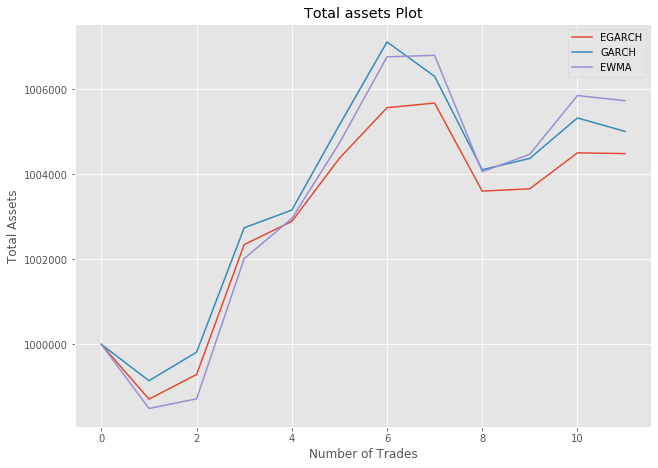

In [22]:
# Plotting total assets for each Method
tot_assets_egarch_series = pd.Series(tot_assets_egarch)
tot_assets_garch_series = pd.Series(tot_assets_garch)
tot_assets_ewma_series = pd.Series(tot_assets_ewma)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])  # main axes
_ = ax.plot(np.arange(len(tot_assets_egarch_series)), tot_assets_egarch_series.values, label='EGARCH')
_ = ax.plot(np.arange(len(tot_assets_garch_series)), tot_assets_garch_series.values, label='GARCH')
_ = ax.plot(np.arange(len(tot_assets_garch_series)), tot_assets_ewma_series.values, label='EWMA')
_ = ax.set_xlabel("Number of Trades")
_ = ax.set_ylabel("Total Assets")
_ = ax.set_title("Total assets Plot")
_ = ax.legend()

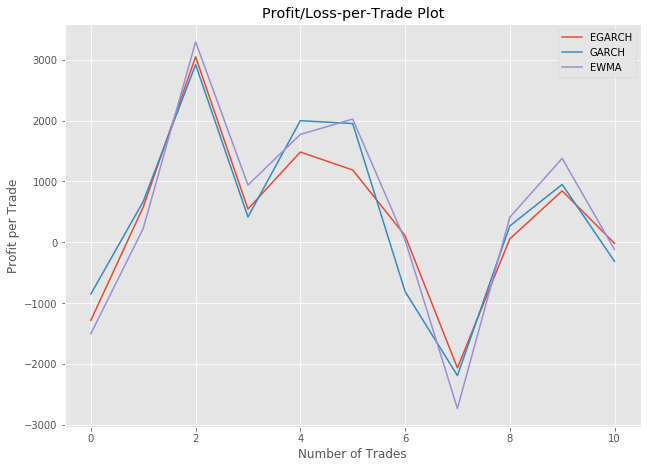

In [23]:
# Plotting the Profit/Loss values per trade for each method
profit_per_trade_egarch_series = pd.Series(profit_per_trade_egarch)
profit_per_trade_garch_series = pd.Series(profit_per_trade_garch)
profit_per_trade_ewma_series = pd.Series(profit_per_trade_ewma)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])  # main axes
_ = ax.plot(np.arange(len(profit_per_trade_egarch_series)), profit_per_trade_egarch_series.values, label='EGARCH')
_ = ax.plot(np.arange(len(profit_per_trade_garch_series)), profit_per_trade_garch_series.values, label='GARCH')
_ = ax.plot(np.arange(len(profit_per_trade_ewma_series)), profit_per_trade_ewma_series.values, label='EWMA')
_ = ax.set_xlabel("Number of Trades")
_ = ax.set_ylabel("Profit per Trade")
_ = ax.set_title("Profit/Loss-per-Trade Plot")
_ = ax.legend()

## References  

[1] https://voxeu.org/article/what-swiss-fx-shock-says-about-risk-models <br>
[2] https://towardsdatascience.com/garch-processes-monte-carlo-simulations-for-analytical-forecast-27edf77b2787 <br>
[3] Meucci, A. (2005) *Risk and Asset Allocation*. Place of Publication: Springer. Springer Finance. <br>
[4] Rowat, C. (2019) *G53 (08 22524): Risk Analytics Syllabus*. University of Birmingham. <br>
[5] https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp <br>
[6] Cherubini, U., Luciano, E., Vecchiato, W. (2004) *Copula Methods in Finance*. Place of Publication: John Wiley & Sons Ltd <br>
[7] Alexander, C. (2012) *Market Risk Analysis: Vol I*. Place of Publication: John Wiley & Sons Ltd. pp. 65-66. <br>
[8] Alexander, C. (2012) *Market Risk Analysis: Vol IV*. Place of Publication: John Wiley & Sons Ltd. <br>